<a href="https://colab.research.google.com/github/cesar-claros/curso_ciencia_datos/blob/main/test2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/cesar-claros/curso_ciencia_datos.git
%cd curso_ciencia_datos/

Cloning into 'curso_ciencia_datos'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
/content/curso_ciencia_datos


# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib.cm import get_cmap

# 2. Load dataset

In [4]:
diabetes_data = pd.read_csv("DiabetesData1.csv", sep=",")
diabetes_data

,Embarazos,Glucosa,Presión_Sanguinea,Insulina,BMI,Función_Predictora,Edad,Resultado
0,0,91,68,210,39.9,0.381,25,0
1,6,85,78,0,31.2,0.382,42,0
2,10,139,80,0,27.1,1.441,57,0
3,1,97,64,82,18.2,0.299,21,0
4,13,152,90,29,26.8,0.731,43,1
...,...,...,...,...,...,...,...,...
321,0,102,86,105,29.3,0.695,27,0
322,2,92,52,0,30.1,0.141,22,0
323,3,115,66,140,38.1,0.150,28,0
324,1,124,74,0,27.8,0.100,30,0


## Set all numeric data types to float32

In [5]:
df = diabetes_data.select_dtypes(exclude=object).astype("float32")
X = df.drop(['Resultado'], axis=1)
Y = df[['Resultado']]

# 3. Exploration of raw data

## 3.1. Correlation of numerical atributes

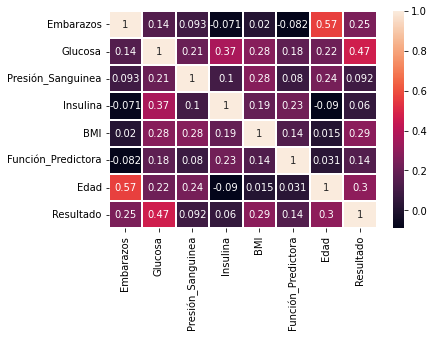

In [7]:
ax = sns.heatmap(df.corr(), annot=True, lw=1)

## 3.3. Countplot

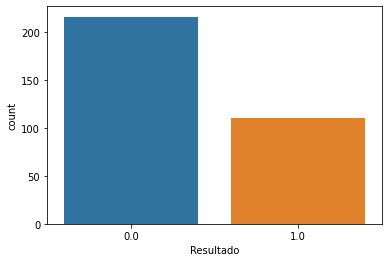

In [8]:
ax = sns.countplot(x="Resultado", data=df)

### This dataset is unbalanced. Therefore, the feature selection and training processes have to be carried out keeping the proportions given by the class label.

# 4. Feature selection


## 4.1. Stratified K-fold Cross-validated Recursive Feature Elimination


In [9]:
n_features = 3
estimator = linear_model.LogisticRegression(max_iter=500)
selector = RFE(estimator=estimator, n_features_to_select=n_features)
skf = StratifiedKFold(n_splits=10)
ranking_list = []
for train_index, test_index in skf.split(X, Y):
    X_train, Y_train = X.iloc[train_index], Y.iloc[train_index]
    selector = selector.fit(X_train, Y_train.values.ravel())
    ranking_list.append(selector.ranking_)
ranking_mat = np.array(ranking_list)
ranking_mat = np.where(ranking_mat==1, ranking_mat, 0)

Text(0.5, 1.0, 'Number of times a feature get selected')

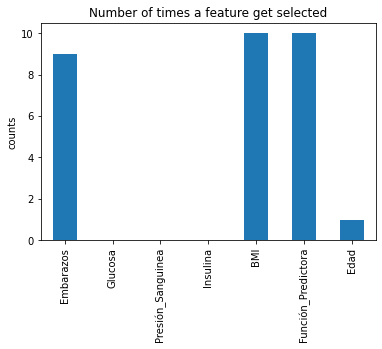

In [10]:
ranking_df = pd.DataFrame(ranking_mat, columns=X.columns.values)
mask = (-ranking_df.sum(axis=0)).argsort()[:n_features]
ax = ranking_df.sum(axis=0).plot.bar()
ax.set_ylabel('counts')
ax.set_title('Number of times a feature get selected')

In [11]:
print('Selected features: ', X.columns[mask.values].values)

Selected features:  ['BMI' 'Función_Predictora' 'Embarazos']


# Question a)
Crea un modelo de regresión logística a 3 variables para predecir la diabetes. Justifica el porqué de tu elección.

We chose 'Embarazos', 'BMI', and 'Funcion_predictora' because they are the ones that get selected more consistently across splits of a stratified K-fold cross validation procedure using RFE as feature selection mechanism.

# 5. Training the model

In [16]:
X_fs = X[X.columns[mask.values].values]
model_lr = linear_model.LogisticRegression(max_iter=500)
model_lr.fit(X_fs,Y.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
# cross-validation procedure
model = linear_model.LogisticRegression(max_iter=500)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_fs, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# Question b)

Realiza una validacion cruzada para justificar la certitud de tu
trabajo. ¿Cuál es el promedio del score de tu validación?

In [18]:
print('Mean accuracy: %.3f:' % (np.mean(n_scores)))

Mean accuracy: 0.719:


# 6. Evaluate the model

## 6.1. Load test instances

In [20]:
diabetes_pred = pd.read_csv("DiabetesPredicciones.csv", sep=",")
diabetes_pred

,Embarazos,Glucosa,Presión_Sanguinea,Insulina,BMI,Función_Predictora,Edad
0,5,115,76,0,31.2,0.343,44
1,13,129,0,0,39.9,0.569,44
2,3,187,70,200,36.4,0.408,36
3,9,122,56,0,33.3,1.114,33
4,8,118,72,0,23.1,1.476,46
...,...,...,...,...,...,...,...
111,3,173,78,185,33.8,0.970,31
112,3,171,72,135,33.3,0.199,24
113,3,112,74,0,31.6,0.197,25
114,1,181,78,293,40.0,1.258,22


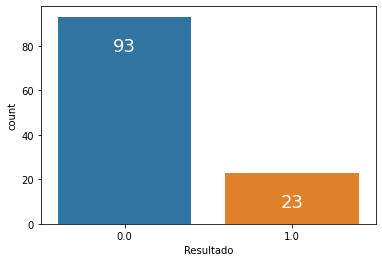

In [21]:
# Pick the features that were selected previously
X_pred = diabetes_pred[X.columns[mask.values].values]
Y_pred = model_lr.predict(X_pred)
Y_pred_df = pd.DataFrame(Y_pred, columns=['Resultado'])
ax = sns.countplot(x="Resultado", data=Y_pred_df)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=18)
plt.show()

# Question c)

En el documento "DiabetesPredicciones.csv" estan una lista de
pacientes que potencialmente pueden tener esta enfermedad, haz
una predicción con este conjunto. ¿Cuántos de ellos dan un
resultado positivo?

In [22]:
print(Y_pred_df.value_counts())
print('\n',Y_pred_df.value_counts()[1].values[0], 'personas dan un resultado positivo')

Resultado
0.0          93
1.0          23
dtype: int64

 23 personas dan un resultado positivo


## 6.2. Load test labels

In [24]:
diabetes_res = pd.read_csv("DiabetesResultados.csv", sep=",")
diabetes_res.value_counts()

Resultado
0            70
1            46
dtype: int64

# Question d)

Si los resultados de los pacientes anteriores se encuentran en el dataset "DiabetesResultados.csv". ¿Cuál es la exactitud, la precisión y la taza de error de la predicción ?

In [25]:
tn, fp, fn, tp = confusion_matrix(diabetes_res,Y_pred_df ).ravel()
print('Exactitud=',(tp/(tp+fp)))
print('Precisión=',(tp/(tp+fn)))
print('Taza de error= %.3f%%' % (100*(1-(tp+tn)/(tp+tn+fp+fn))))

Exactitud= 0.7391304347826086
Precisión= 0.3695652173913043
Taza de error= 30.172%
